In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, ll_to_xy,latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim
import pandas as pd
from netCDF4 import Dataset
import netCDF4
import h5py as h5
import csv
from scipy import stats
import seaborn as sns
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [3]:
def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))
def mean(data):
    mean = sum(data)/len(data)
    return(mean)

In [13]:
# Open the NetCDF file
filename = "440ERA5SEEDED"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

# GETTING DATA
slp = getvar(ncfile2, "slp")
snow = ncfile2['QSNOW'][:].squeeze()
cloud = ncfile2['QCLOUD'][:].squeeze()
ice = ncfile2['QICE'][:].squeeze()
rain = ncfile2['QRAIN'][:].squeeze()
grop = ncfile2['QGRAUP'][:].squeeze()
total_ice = snow + ice + grop
seed_material = ncfile2['QNA1'][:].squeeze()
seed = np.max(seed_material, axis = 0)
# Open the NetCDF file
filename = "440ERA5S"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

# GETTING DATA
slp = getvar(ncfile2, "slp")
snow = ncfile2['QSNOW'][:].squeeze()
cloud = ncfile2['QCLOUD'][:].squeeze()
ice = ncfile2['QICE'][:].squeeze()
rain = ncfile2['QRAIN'][:].squeeze()
grop = ncfile2['QGRAUP'][:].squeeze()
total_ice2 = snow + ice + grop

total_ice = total_ice - total_ice2

# BASE CALCULATIONS

P = ncfile2['P'][:].squeeze()
PB = ncfile2['PB'][:].squeeze()
PHB = ncfile2['PHB'][:].squeeze()
PH = ncfile2['PH'][:].squeeze()
lat = ncfile2['XLAT'][:].squeeze()
lon = ncfile2['XLONG'][:].squeeze()
Tv = getvar(ncfile2, 'tv', units = 'K', meta = False)
PRES = wrf_pres(P,PB)/100

THETA = ncfile2['T'][:].squeeze()
THETA = wrf_theta(THETA)
TEMP = wrf_temp(THETA,PRES).squeeze()
HEIGHT = wrf_height(PH,PHB)
PRES = PRES*100
Density = PRES/(287.16*Tv)

delta_z = np.zeros((80,600,900))

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
request = cimgt.StamenTerrain()   # very responsive
crg = request.crs
z = 0
u = 0
while z< 600:
    while u < 900:
        new = crg.transform_point(lon[z,u], lat[z,u], crs.Geodetic())
        lon[z,u] = new[0]
        lat[z,u] = new[1]
        u = u + 1
    z = z + 1
    u = 0

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  """


In [24]:
#HEIGHT AGL AND DELTA Z
ter = getvar(ncfile2, "ter", units = 'm', meta= False)
z=0
height_agl = HEIGHT
while z < 80:
    height_agl[z,:,:] = height_agl[z,0:600,0:900]-ter[0:600,0:900]
    z = z + 1
    
z=0
while z < 80:
    delta_z[z,:,:] = height_agl[z+1,:,:] - height_agl[z,:,:]
    z = z + 1

#IWP CALCULATIONS
IWP = Density[:,:,:]*total_ice[:,:,:]*delta_z[:,:,:]
total = np.zeros((600,900))
z=0
while z < 80:
    adder = IWP[z,:,:]
    total = total + adder
    z = z + 1
total_IWP = total
total_IWP.squeeze()

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., -8.266470786902102e-07,
         -1.0442066571731352e-06, 0.0],
        [0.0, 0.0, 0.0, ..., -5.092835287486409e-06,
         -5.4940723720975864e-06, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., -0.018628574060312614,
         -0.0076827672048528275, 0.0],
        [0.0, 0.0, 0.0, ..., -0.00568651782748047,
         -0.0031601696492581694, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [18]:
print(delta_z[:,300,300])
print(HEIGHT[:,300,300])

[  17.52508545   17.95135498   18.37994385   18.76330566   19.50939941
   20.42449951   21.53747559   22.87335205   24.45928955   26.3336792
   28.53509521   31.09680176   34.05456543   37.43652344   41.26721191
   45.59765625   50.49963379   56.17358398   62.68164062   69.84545898
   77.5435791    85.82531738   94.78540039   94.64892578   94.56445312
   94.57922363   94.64868164   94.70324707   94.72485352   94.74951172
   94.73095703   94.70581055   94.66992188   94.61157227   94.5144043
   94.3684082    94.18237305   93.97192383   93.73535156   93.4777832
   93.22045898   92.97607422   92.74536133  102.14941406  112.31713867
  123.2722168   134.9765625   147.42285156  160.60400391  174.52246094
  189.18505859  204.54223633  220.52539062  237.08398438  254.20507812
  271.93261719  290.41601562  309.94824219  330.61328125  352.10253906
  373.85644531  395.421875    416.25390625  436.20507812  455.9609375
  476.97363281  500.68457031  528.18554688  560.52246094  598.68652344
  643.4667

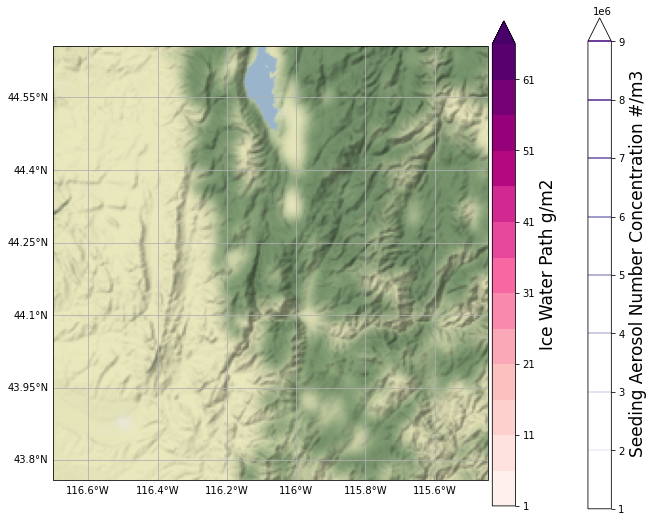

In [45]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(projection = crg)

# specify map extent here
lonmin, lonmax = -116.70062, -115.44735
latmin, latmax = 43.756786, 44.655064

LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
EW = UR[0] - LL[0]
SN = UR[1] - LL[1]
side = max(EW,SN)
mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
ax.set_extent(extent, crs=crg)
ax.add_image(request, 8)

rlevs = np.arange(1,70,5)

cont = ax.contourf(lon[269:385,343:456], lat[269:385,343:456], total_IWP[269:385,343:456]*1000, rlevs,cmap=get_cmap("RdPu"), extend = "max")
rlevs = np.arange(1000000,10000000,1000000)
cont3 = ax.contour(lon[269:385,343:456], lat[269:385,343:456], seed[269:385,343:456],rlevs,cmap=get_cmap("Purples"), extend = "max")
cbr3 = plt.colorbar(cont3,fraction=0.0419, pad=0.13)
cbr3.set_label('Seeding Aerosol Number Concentration #/m3', fontsize = 17)
cbr = plt.colorbar(cont,fraction=0.05, pad=0.01)
cbr.set_label('Ice Water Path g/m2', fontsize = 17)

In [9]:
#For Multi-Plots

In [19]:
hour_list = ['300','310','320','330','340','350','400','410','420','430','440','450','500','510','520','530','540','550','600']
#hour_list = ['400','410','420','430','440','450','500','510','520','530','540','550','600']

300
310
320
330
340


KeyboardInterrupt: 

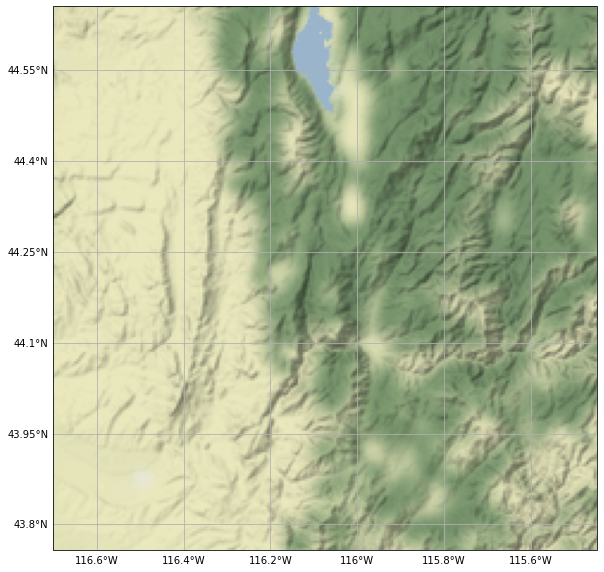

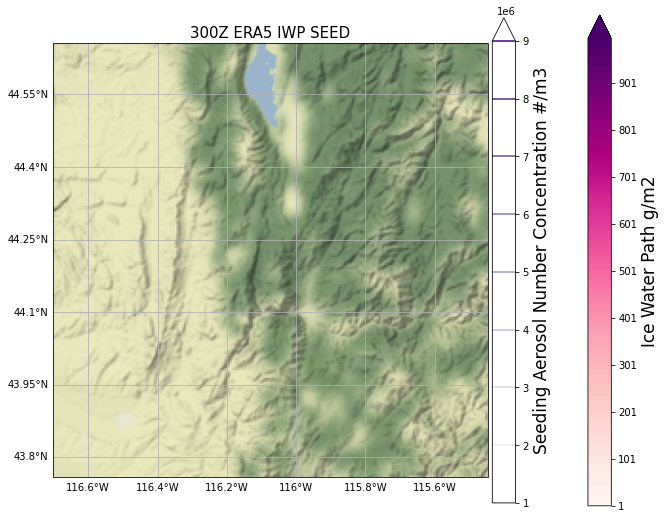

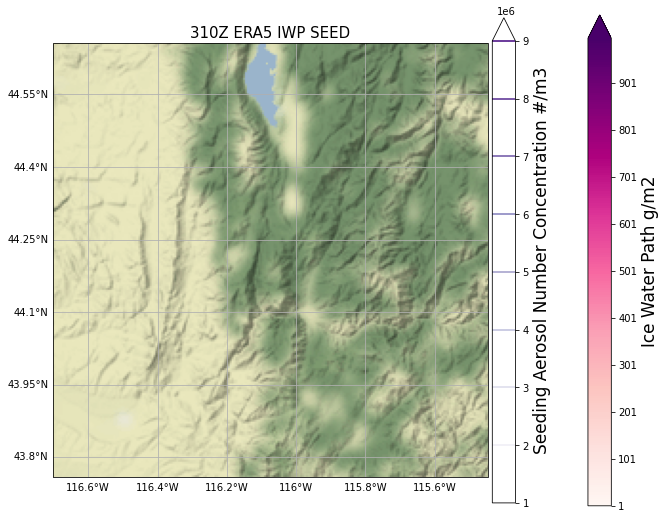

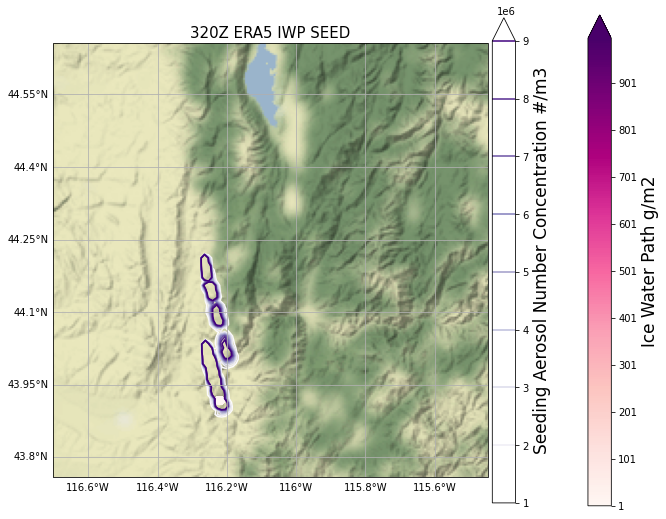

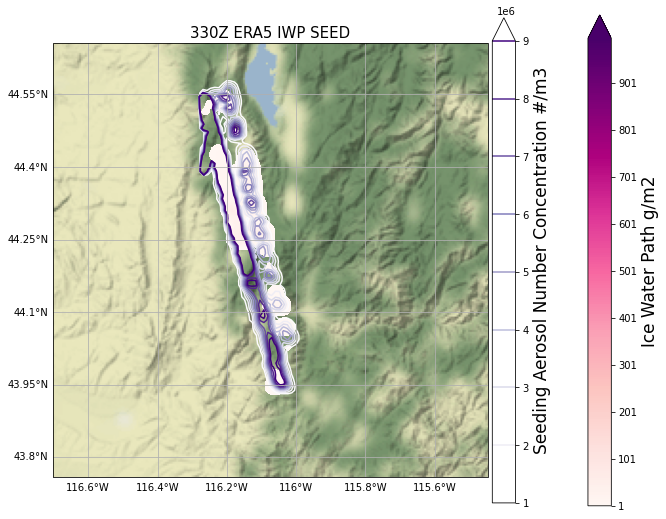

In [19]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(projection = crg)

# specify map extent here
lonmin, lonmax = -116.70062, -115.44735
latmin, latmax = 43.756786, 44.655064

LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
EW = UR[0] - LL[0]
SN = UR[1] - LL[1]
side = max(EW,SN)
mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
ax.set_extent(extent, crs=crg)
ax.add_image(request, 8)

rlevs = np.arange(1,70,5)
for hour in hour_list:
    print(hour)
    ctrl_file = hour+"ERA5S"
    seed_file = hour+"ERA5SEEDED"
    pic_name = hour+"IWP_DIFFERENCE_ERA5.png"
    title = hour + "Z ERA5 IWP SEED"
    
    # Open the NetCDF file
    filename = seed_file
    ncfile2 = Dataset(filename)

    # GETTING DATA
    slp = getvar(ncfile2, "slp")
    snow = ncfile2['QSNOW'][:].squeeze()
    cloud = ncfile2['QCLOUD'][:].squeeze()
    ice = ncfile2['QICE'][:].squeeze()
    rain = ncfile2['QRAIN'][:].squeeze()
    grop = ncfile2['QGRAUP'][:].squeeze()
    total_ice = snow + ice + grop
    seed_material = ncfile2['QNA1'][:].squeeze()
    seed = np.max(seed_material, axis = 0)

    # Open the NetCDF file
    filename = ctrl_file
    ncfile2 = Dataset(filename)

    # GETTING DATA
    snow = ncfile2['QSNOW'][:].squeeze()
    cloud = ncfile2['QCLOUD'][:].squeeze()
    ice = ncfile2['QICE'][:].squeeze()
    rain = ncfile2['QRAIN'][:].squeeze()
    grop = ncfile2['QGRAUP'][:].squeeze()
    total_ice2 = snow + ice + grop

    total_ice = total_ice - total_ice2

    # BASE CALCULATIONS

    P = ncfile2['P'][:].squeeze()
    PB = ncfile2['PB'][:].squeeze()
    PHB = ncfile2['PHB'][:].squeeze()
    PH = ncfile2['PH'][:].squeeze()
    Tv = getvar(ncfile2, 'tv', units = 'K', meta = False)
    PRES = wrf_pres(P,PB)/100

    THETA = ncfile2['T'][:].squeeze()
    THETA = wrf_theta(THETA)
    TEMP = wrf_temp(THETA,PRES).squeeze()
    HEIGHT = wrf_height(PH,PHB)
    PRES = PRES*100
    Density = PRES/(287.16*Tv)

    delta_z = np.zeros((80,600,900))
    #HEIGHT AGL AND DELTA Z
    ter = getvar(ncfile2, "ter", units = 'm', meta= False)
    z=0
    height_agl = HEIGHT
    while z < 80:
        height_agl[z,:,:] = height_agl[z,0:600,0:900]-ter[0:600,0:900]
        z = z + 1

    z=0
    while z < 80:
        delta_z[z,:,:] = height_agl[z+1,:,:] - height_agl[z,:,:]
        z = z + 1

    #IWP CALCULATIONS
    IWP = Density[:,:,:]*total_ice[:,:,:]*delta_z[:,:,:]
    total = np.zeros((600,900))
    z=0
    while z < 80:
        adder = IWP[z,:,:]
        total = total + adder
        z = z + 1
    total_IWP = total
    total_IWP.squeeze()
    fig, ax = make_map(projection = crg)

    # specify map extent here
    lonmin, lonmax = -116.70062, -115.44735
    latmin, latmax = 43.756786, 44.655064

    LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
    UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
    EW = UR[0] - LL[0]
    SN = UR[1] - LL[1]
    side = max(EW,SN)
    mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

    extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
    ax.set_extent(extent, crs=crg)
    ax.add_image(request, 8)

    rlevs = np.arange(1,1000,5)

    cont = ax.contourf(lon[269:385,343:456], lat[269:385,343:456], total_IWP[269:385,343:456]*1000, rlevs,cmap=get_cmap("RdPu"), extend = "max")
    cbr = plt.colorbar(cont,fraction=0.0419, pad=0.13)
    rlevs = np.arange(1000000,10000000,1000000)

    cont3 = ax.contour(lon[269:385,343:456], lat[269:385,343:456], seed[269:385,343:456],rlevs,cmap=get_cmap("Purples"), extend = "max")
    cbr3 = plt.colorbar(cont5,fraction=0.05, pad=0.01)
    cbr3.set_label('Seeding Aerosol Number Concentration #/m3', fontsize = 17)
    plt.title(title, fontsize = 15)
    cbr.set_label('Ice Water Path g/m2', fontsize = 17)
    plt.savefig(pic_name, dpi = 400)

300
310
320
330
340
350
400
410
420
430
440
450
500
510
520
530
540
550
600


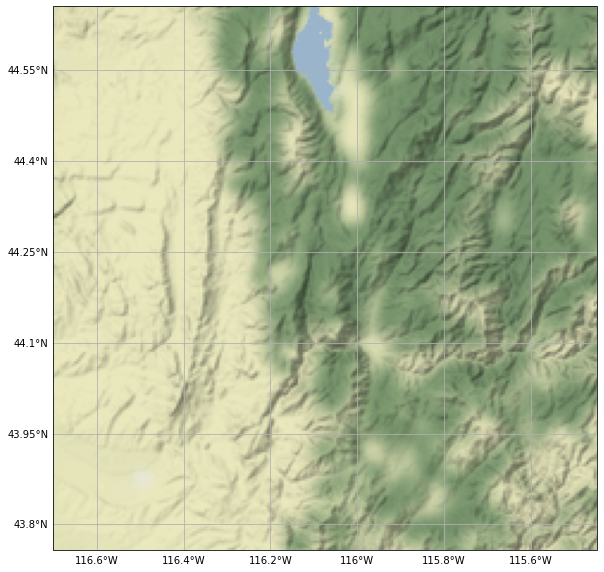

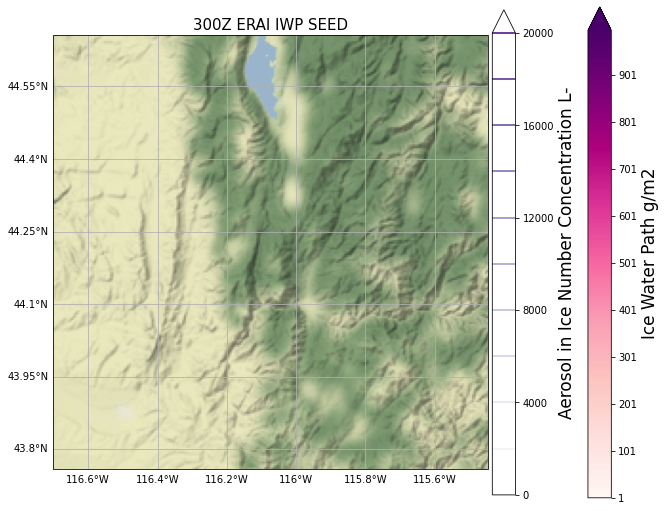

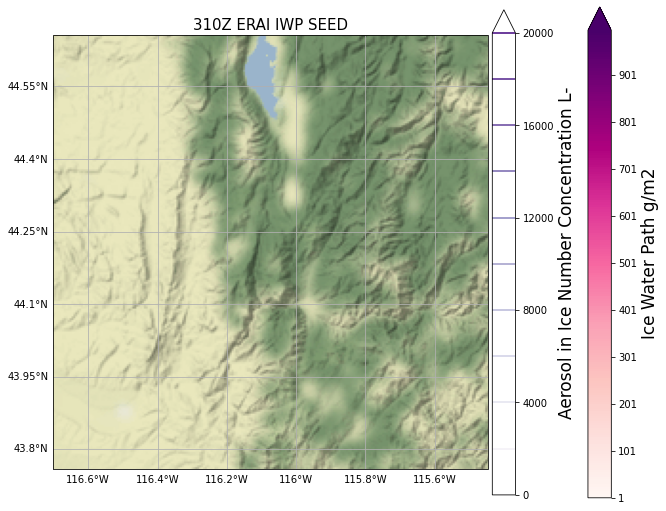

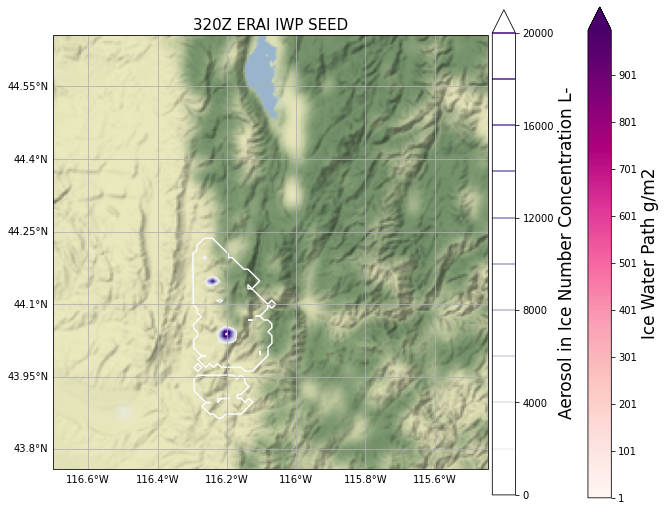

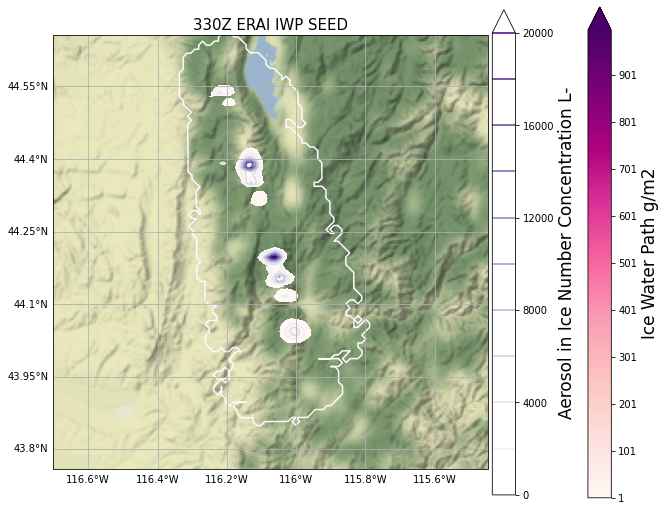

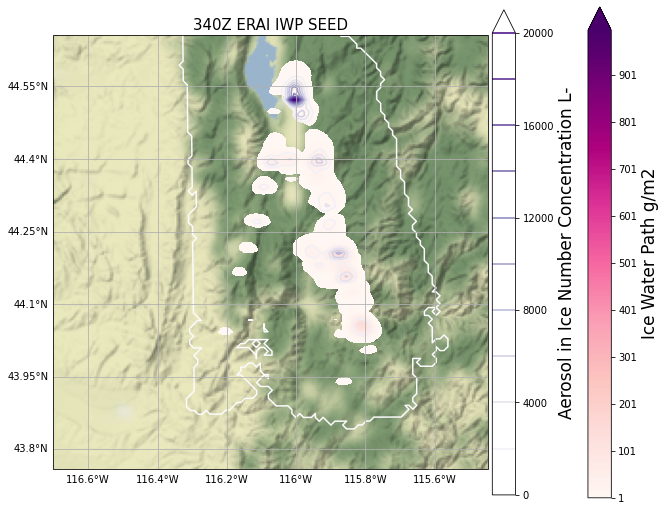

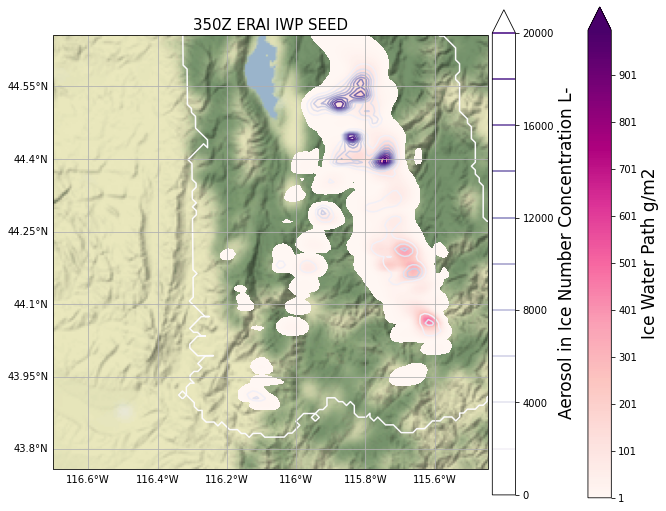

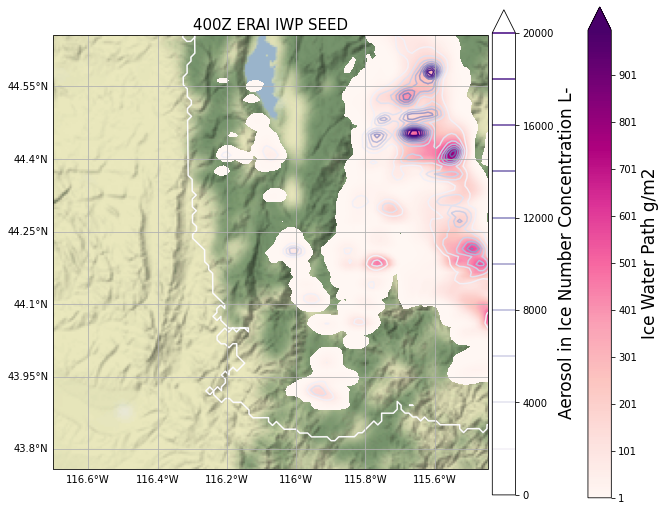

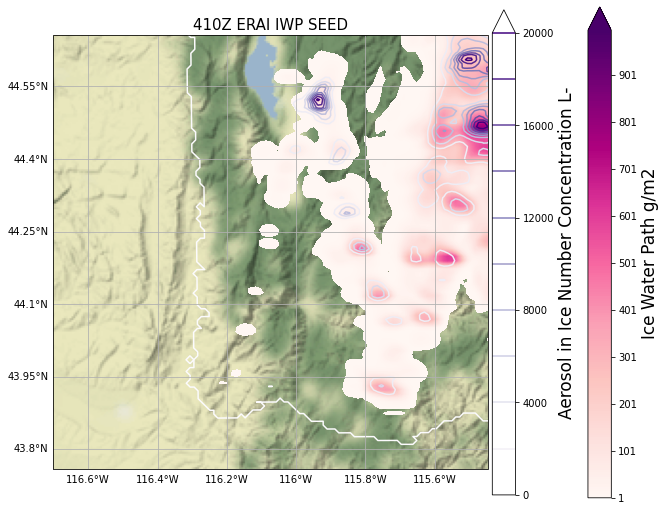

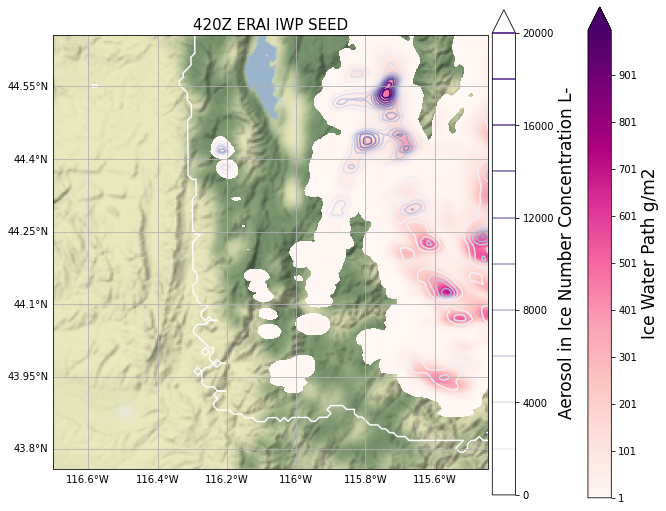

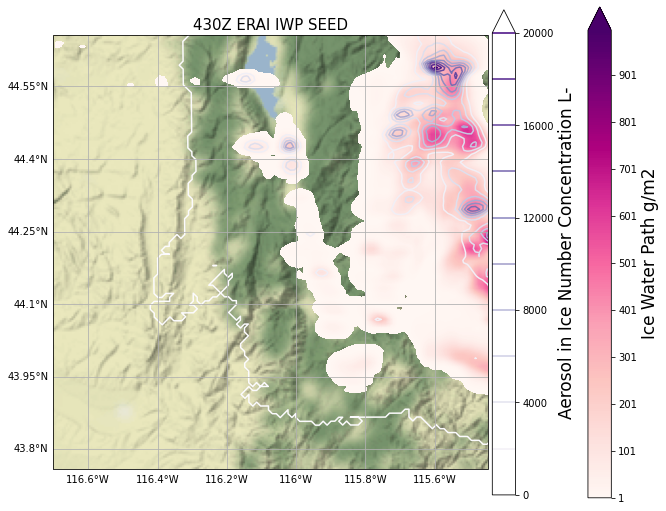

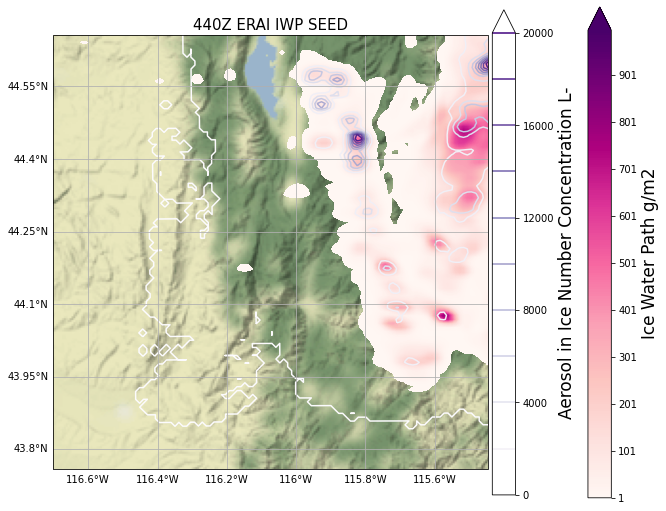

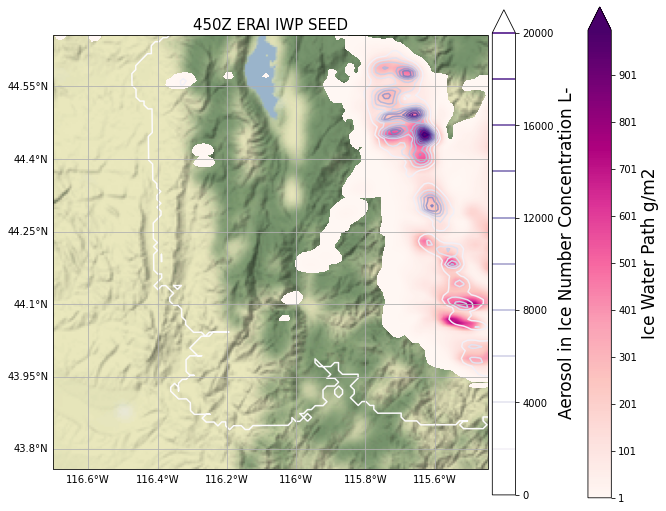

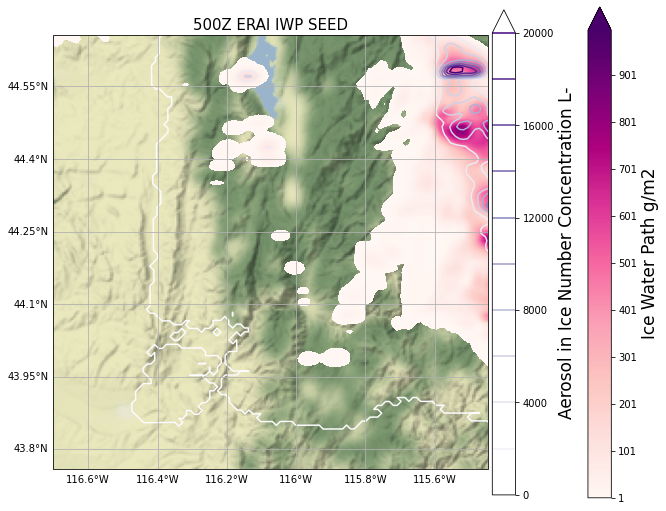

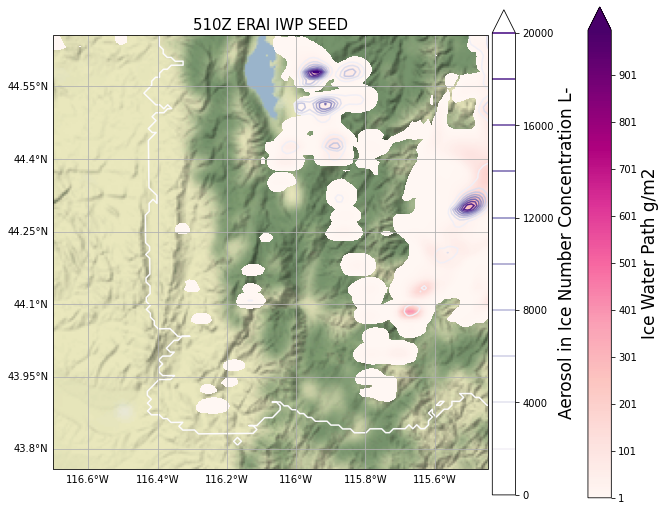

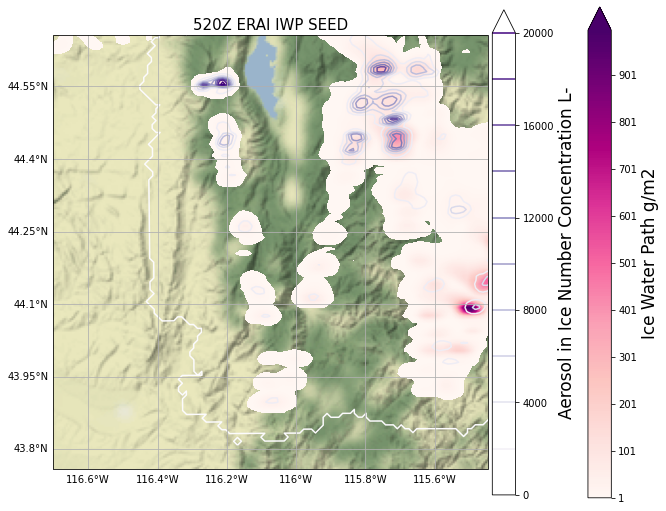

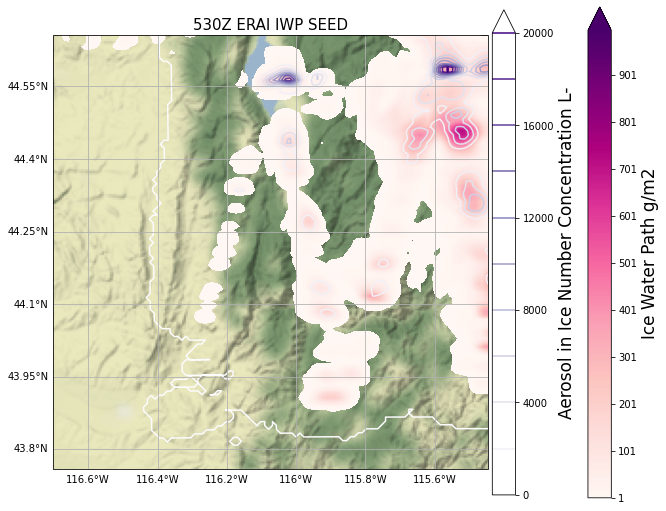

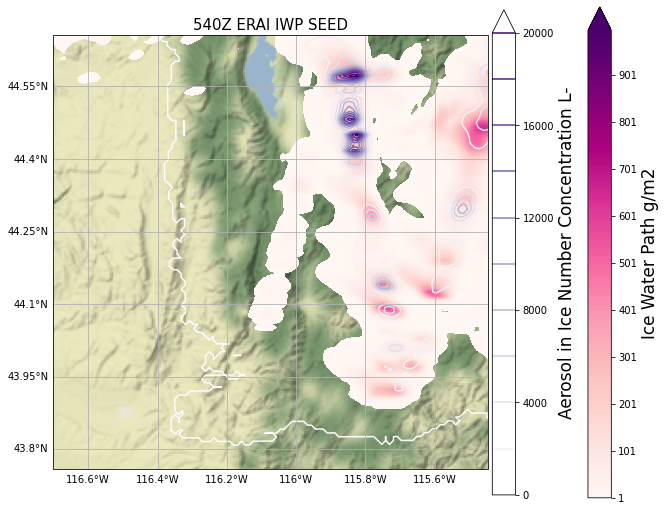

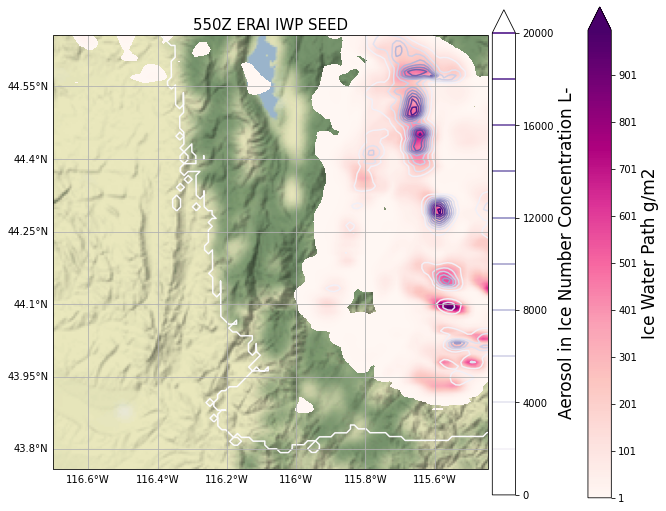

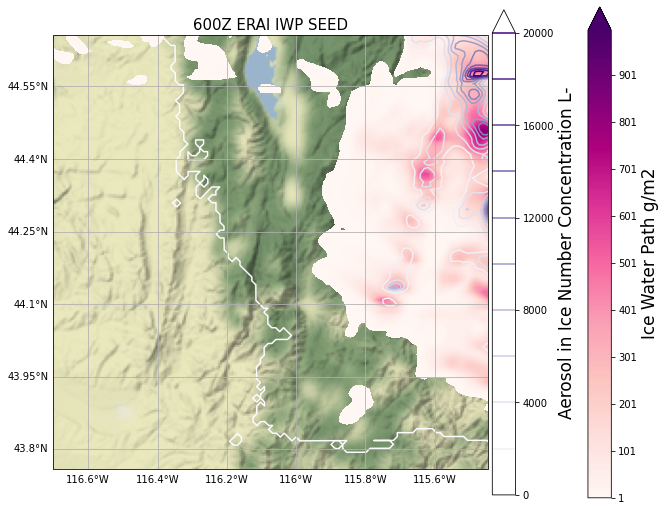

In [23]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(projection = crg)

# specify map extent here
lonmin, lonmax = -116.70062, -115.44735
latmin, latmax = 43.756786, 44.655064

LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
EW = UR[0] - LL[0]
SN = UR[1] - LL[1]
side = max(EW,SN)
mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
ax.set_extent(extent, crs=crg)
ax.add_image(request, 8)

rlevs = np.arange(1,70,5)
for hour in hour_list:
    print(hour)
    ctrl_file = hour+"ERAIS"
    seed_file = hour+"ERAISEEDED"
    pic_name = hour+"IWP_AEROINICE_ERAI.png"
    title = hour + "Z ERAI IWP SEED"
    
    # Open the NetCDF file
    filename = seed_file
    ncfile2 = Dataset(filename)

    # GETTING DATA
    ice_carried = ncfile2['QNA1ICE'][:].squeeze()*Density
    snow_carried = ncfile2['QNA1SNOW'][:].squeeze()*Density
    graupel_carried = ncfile2['QNA1GRAUPEL'][:].squeeze()*Density
    ice_carried_max = (sum(ice_carried) + sum(snow_carried) + sum(graupel_carried))/1000
    slp = getvar(ncfile2, "slp")
    snow = ncfile2['QSNOW'][:].squeeze()
    cloud = ncfile2['QCLOUD'][:].squeeze()
    ice = ncfile2['QICE'][:].squeeze()
    rain = ncfile2['QRAIN'][:].squeeze()
    grop = ncfile2['QGRAUP'][:].squeeze()
    total_ice = snow + ice + grop
    seed_material = ncfile2['QNA1'][:].squeeze()
    seed = np.max(seed_material, axis = 0)

    # Open the NetCDF file
    filename = ctrl_file
    ncfile2 = Dataset(filename)

    # GETTING DATA
    snow = ncfile2['QSNOW'][:].squeeze()
    cloud = ncfile2['QCLOUD'][:].squeeze()
    ice = ncfile2['QICE'][:].squeeze()
    rain = ncfile2['QRAIN'][:].squeeze()
    grop = ncfile2['QGRAUP'][:].squeeze()
    total_ice2 = snow + ice + grop

    total_ice = total_ice - total_ice2

    # BASE CALCULATIONS

    P = ncfile2['P'][:].squeeze()
    PB = ncfile2['PB'][:].squeeze()
    PHB = ncfile2['PHB'][:].squeeze()
    PH = ncfile2['PH'][:].squeeze()
    Tv = getvar(ncfile2, 'tv', units = 'K', meta = False)
    PRES = wrf_pres(P,PB)/100

    THETA = ncfile2['T'][:].squeeze()
    THETA = wrf_theta(THETA)
    TEMP = wrf_temp(THETA,PRES).squeeze()
    HEIGHT = wrf_height(PH,PHB)
    PRES = PRES*100
    Density = PRES/(287.16*Tv)

    delta_z = np.zeros((80,600,900))
    #HEIGHT AGL AND DELTA Z
    ter = getvar(ncfile2, "ter", units = 'm', meta= False)
    z=0
    height_agl = HEIGHT
    while z < 80:
        height_agl[z,:,:] = height_agl[z,0:600,0:900]-ter[0:600,0:900]
        z = z + 1

    z=0
    while z < 80:
        delta_z[z,:,:] = height_agl[z+1,:,:] - height_agl[z,:,:]
        z = z + 1

    #IWP CALCULATIONS
    IWP = Density[:,:,:]*total_ice[:,:,:]*delta_z[:,:,:]
    total = np.zeros((600,900))
    z=0
    while z < 80:
        adder = IWP[z,:,:]
        total = total + adder
        z = z + 1
    total_IWP = total
    total_IWP.squeeze()
    fig, ax = make_map(projection = crg)

    # specify map extent here
    lonmin, lonmax = -116.70062, -115.44735
    latmin, latmax = 43.756786, 44.655064

    LL = crg.transform_point(lonmin, latmin, ccrs.Geodetic())
    UR = crg.transform_point(lonmax, latmax, ccrs.Geodetic())
    EW = UR[0] - LL[0]
    SN = UR[1] - LL[1]
    side = max(EW,SN)
    mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0  #center location

    extent = [mid_x-side/2.0, mid_x+side/2.0, mid_y-side/2.0, mid_y+side/2.0]   # map coordinates, meters
    ax.set_extent(extent, crs=crg)
    ax.add_image(request, 8)

    rlevs = np.arange(1,1000,5)

    cont = ax.contourf(lon[269:385,343:456], lat[269:385,343:456], total_IWP[269:385,343:456]*1000, rlevs,cmap=get_cmap("RdPu"), extend = "max")
    cbr = plt.colorbar(cont,fraction=0.0419, pad=0.13)
    rlevs = np.arange(100,20000,1000)

    cont3 = ax.contour(lon[269:385,343:456], lat[269:385,343:456],ice_carried_max[269:385,343:456],10,cmap=get_cmap("Purples"), extend = "max")
    cbr3 = plt.colorbar(cont5,fraction=0.05, pad=0.01)
    cbr3.set_label('Aerosol in Ice Number Concentration L-', fontsize = 17)
    plt.title(title, fontsize = 15)
    cbr.set_label('Ice Water Path g/m2', fontsize = 17)
    plt.savefig(pic_name, dpi = 400)

In [9]:
ncfile2 = Dataset("300NARRSEED")

FileNotFoundError: [Errno 2] No such file or directory: b'300NARRSEED'

In [6]:
filename = "440ERA5SEEDED"
ncfile2 = Dataset(filename)
snow_carried = ncfile2['QNA1SNOW'][:].squeeze()

(600, 900)